In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Pre processing

Let's load the pathes to the data we want to use and print the size of each set.

In [ ]:
# Train data
train_labels_path = "/content/drive/MyDrive/Final_Project_DNN/train/labels"
train_img_path = "/content/drive/MyDrive/Final_Project_DNN/train/images"
train_label_files = os.listdir(train_labels_path)
train_image_files = os.listdir(train_img_path)

# Validation data
validation_labels_path = "/content/drive/MyDrive/Final_Project_DNN/validation/labels"
validation_img_path = "/content/drive/MyDrive/Final_Project_DNN/validation/images"
validation_label_files = os.listdir(validation_labels_path)
validation_image_files = os.listdir(validation_img_path)

# Test data
test_labels_path = "/content/drive/MyDrive/Final_Project_DNN/test/labels"
test_img_path = "/content/drive/MyDrive/Final_Project_DNN/test/images"
test_label_files = os.listdir(test_labels_path)
test_image_files = os.listdir(test_img_path)

In [ ]:
print(f"Train size: {len(train_label_files)}")
print(f"Validation size: {len(validation_label_files)}")
print(f"Test size: {len(test_label_files)}")


Train size: 16221
Validation size: 1000
Test size: 4306


In [ ]:

def resize_image(image_path, output_size=(256, 256)):
    """Resizes the image to the specified output size."""
    image = Image.open(image_path)
    resized_image = image.resize(output_size)
    return image, resized_image

def visualize_before_after(original, resized):
    """Visualizes the original and resized images side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(resized)
    ax[1].set_title("Resized Image")
    ax[1].axis('off')

    plt.show()

In [ ]:
import cv2

def parse_label_file(file_path):
    with open(file_path, 'r') as file:
        boxes = np.array([list(map(float, line.strip().split())) for line in file])
        if boxes.size == 0:
            return np.array([]), np.array([])
        labels = boxes[:,0].astype(int)
        boxes = boxes[:,1:]
    return labels, boxes


Below an example of an image resized is shown.

(640, 352)


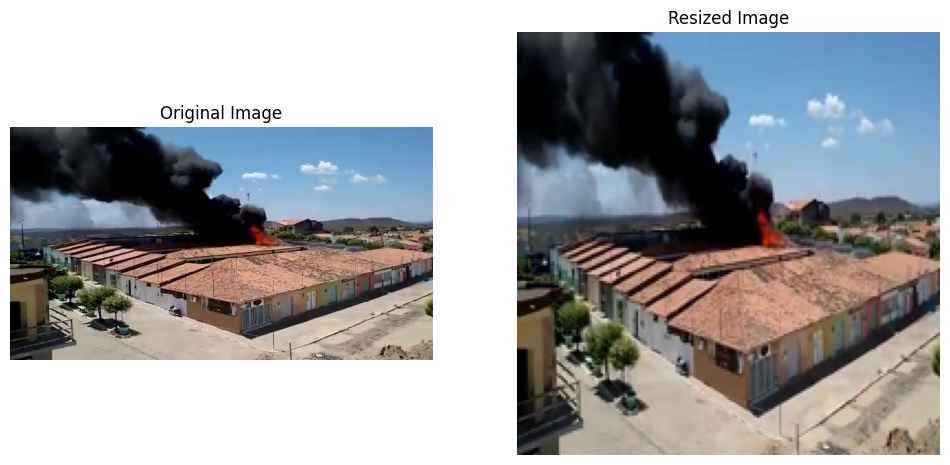

In [ ]:
training_image = os.path.join(train_img_path, train_image_files[162])
original, resized = resize_image(training_image, output_size = (192, 192))
visualize_before_after(original, resized)

## Images Resized

Below we are creating functions in order to resize the entire data and save it. There is the need to redefine the resize images in order to use the cv2 library and save the images.

In [ ]:
from tqdm import tqdm
import cv2
import glob
import os
import shutil
from concurrent.futures import ThreadPoolExecutor

def resize_save_images(image_path, new_path, new_size = (256, 256)):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, new_size)
    cv2.imwrite(new_path, resized_image)

def process_images(image_paths, src_dir, dest_dir, existing_files):
    with ThreadPoolExecutor(max_workers=4) as executor:
        for image_path in tqdm(image_paths):
            image_name = image_path.split('/')[-1]
            if image_name not in existing_files:
                src_path = os.path.join(src_dir, image_name)
                dest_path = os.path.join(dest_dir, image_name)
                executor.submit(resize_save_images, src_path, dest_path)

# Copy images to local storage for faster access
local_storage_path = "/content/local_images"
shutil.copytree("/content/drive/MyDrive/Final_Project_DNN", local_storage_path)

# Process train, validation, and test images
for folder in tqdm(["train", "validation", "test"]):
  image_dir = os.path.join(local_storage_path, "images")
  resized_dir = os.path.join(local_storage_path, "images_resized")
  os.makedirs(resized_dir, exist_ok=True)
  existing_files = set(os.listdir(resized_dir))
  image_paths = glob.glob(f"{image_dir}/*.jpg")

process_images(image_paths, image_dir, resized_dir, existing_files)

# Copy processed images back to Google Drive
shutil.copytree("/content/local_images/test/images_resized", "/content/drive/MyDrive/Final_Project_DNN/test/images_resized")
shutil.copytree("/content/local_images/validation/images_resized", "/content/drive/MyDrive/Final_Project_DNN/validation/images_resized")
shutil.copytree("/content/local_images/train/images_resized", "/content/drive/MyDrive/Final_Project_DNN/train/images_resized_n")

'/content/drive/MyDrive/Final_Project_DNN/validation/images_resized'

In [ ]:
len(os.listdir("/content/local_images/images"))
image_path = "/content/local_images/images_resized/AoF00001.jpg"
image = cv2.imread(image_path)
image.shape

(256, 256, 3)

## Smaller training set

Let's create a smaller training set to allow "faster" running times in the model.

In [ ]:
import random
import shutil
from tqdm import tqdm

# Define the source and destination directories
source_images_dir = '/content/drive/MyDrive/Final_Project_DNN/train/images_resized'
source_labels_dir = '/content/drive/MyDrive/Final_Project_DNN/train/labels'
small_training_set = 'content/drive/MyDrive/Final_Project_DNN/small_train_set'
dest_images_dir = '/content/drive/MyDrive/Final_Project_DNN/small_train_set/images_resized'
dest_labels_dir = '/content/drive/MyDrive/Final_Project_DNN/small_train_set/labels'

# Number of samples to copy
num_samples = 5000

# Ensure destination directories exist
os.makedirs(small_training_set, exist_ok=True)
os.makedirs(dest_images_dir, exist_ok=True)
os.makedirs(dest_labels_dir, exist_ok=True)

# Get a list of filenames from the source images directory
image_files = os.listdir(source_images_dir)

# Shuffle the list to ensure random selection
random.shuffle(image_files)

# Select the first 'num_samples' files
selected_files = image_files[:num_samples]

# Copy the selected image and label files to the destination directories
for filename in tqdm(selected_files):

    # Image new path
    new_path_image = os.path.join(dest_images_dir, filename)

    # Copy image
    shutil.copy(os.path.join(source_images_dir, filename), new_path_image)

    # Construct the label filename (assuming same name but different extension)
    label_filename = os.path.splitext(filename)[0] + '.txt'  # Replace with actual label extension if different

    # Check if label file exists, then copy
    if os.path.exists(os.path.join(source_labels_dir, label_filename)):
        shutil.copy(os.path.join(source_labels_dir, label_filename), os.path.join(dest_labels_dir, label_filename))

print(f"Copied {num_samples} samples to the destination directories.")

100%|██████████| 5000/5000 [08:22<00:00,  9.94it/s]

Copied 5000 samples to the destination directories.


In [ ]:
a = os.listdir("/content/drive/MyDrive/Final_Project_DNN/small_train_set/images_resized")
b = os.listdir("/content/drive/MyDrive/Final_Project_DNN/small_train_set/labels")
print(len(a), len(b))

5000 5000


In [ ]:
# Check if the folder exists
folder_path = "/content/drive/MyDrive/Final_Project_DNN/small_train_set/labels"
if os.path.exists(folder_path):
    # Remove the folder and all its contents
    shutil.rmtree(folder_path)
    print(f"The folder '{folder_path}' has been deleted.")

else:
    print(f"The folder '{folder_path}' does not exist.")

The folder '/content/drive/MyDrive/Final_Project_DNN/small_train_set/labels' does not exist.
